In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.io import arff

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.inspection import permutation_importance

from six import StringIO  
from IPython.display import Image  
import pydotplus

### Introduction

For this project I have decided to use a dataset containing information about two rice species, Osmanik and Cammeo. This data was obtained from the UCI ML data repository and is cited below. The data was created by processing pictures of rice grains and calculating the features in the dataset. A total of seven morphological features were measured for each sample and assigned to one of the two species.

#### Citation

Rice (Cammeo and Osmancik). (2019). UCI Machine Learning Repository. https://doi.org/10.24432/C5MW4Z.

### Purpose and goals

The purpose of this project is to create a classifier that can accurately classify what species of rice a specifc sample belongs to. I will create a decision tree classifier for this problem and also use random forest to help pick the most important features. I want to be able to build upon the knowledge I gain while going through this process and end up with a classifier stronger than the base decision tree I will create. Since the features are all measurements from pictures, there will be correlation and I also want to be able to determine the best features to use for the decision tree model.

### Bring in and inspect data

In [2]:
data = arff.loadarff('Rice_Cammeo_Osmancik.arff')

Create a dataframe using the data

In [3]:
df = pd.DataFrame(data[0])

In [4]:
df.shape

(3810, 8)

The data includes 3810 observations and 7 features to use for classification. The additional column is the Class column which is what will be predicted.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3810 entries, 0 to 3809
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Area               3810 non-null   float64
 1   Perimeter          3810 non-null   float64
 2   Major_Axis_Length  3810 non-null   float64
 3   Minor_Axis_Length  3810 non-null   float64
 4   Eccentricity       3810 non-null   float64
 5   Convex_Area        3810 non-null   float64
 6   Extent             3810 non-null   float64
 7   Class              3810 non-null   object 
dtypes: float64(7), object(1)
memory usage: 238.2+ KB


After checking the info related to the dataframe, I can see that there are no missing values and except for the prediction column "Class" all features are numerical.

In [6]:
df.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,15231.0,525.578979,229.749878,85.093788,0.928882,15617.0,0.572896,b'Cammeo'
1,14656.0,494.311005,206.020065,91.730972,0.895405,15072.0,0.615436,b'Cammeo'
2,14634.0,501.122009,214.106781,87.768288,0.912118,14954.0,0.693259,b'Cammeo'
3,13176.0,458.342987,193.337387,87.448395,0.891861,13368.0,0.640669,b'Cammeo'
4,14688.0,507.166992,211.743378,89.312454,0.906691,15262.0,0.646024,b'Cammeo'


Initial inspection shows that the "Class" column is not formatted correctly and all of the other columns are floats. I will clean the "Class" column and convert "Area" and "Convex_Area" to integers since they are whole numbers. 

### Data Cleaning

In [7]:
df.Class.unique()

array([b'Cammeo', b'Osmancik'], dtype=object)

In [8]:
df.replace(to_replace={b'Cammeo':"Cammeo",b'Osmancik':"Osmancik"},inplace=True)

In [9]:
df.Class.unique()

array(['Cammeo', 'Osmancik'], dtype=object)

In [10]:
df=df.astype({'Area':'int64','Convex_Area':'int64'})

In [11]:
df.head(2)

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,15231,525.578979,229.749878,85.093788,0.928882,15617,0.572896,Cammeo
1,14656,494.311005,206.020065,91.730972,0.895405,15072,0.615436,Cammeo


### Description of features

In [12]:
df.describe()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent
count,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000
mean,12667.727559,454.239180,188.776222,86.313750,0.886871,12952.496850,0.661934
std,1732.367706,35.597081,17.448679,5.729817,0.020818,1776.972042,0.077239
min,7551.000000,359.100006,145.264465,59.532406,0.777233,7723.000000,0.497413
25%,11370.500000,426.144753,174.353855,82.731695,0.872402,11626.250000,0.598862
50%,12421.500000,448.852493,185.810059,86.434647,0.889050,12706.500000,0.645361
75%,13950.000000,483.683746,203.550438,90.143677,0.902588,14284.000000,0.726562
max,18913.000000,548.445984,239.010498,107.542450,0.948007,19099.000000,0.861050


The .describe() function is showing some summary statistics for the features that will be used to make the predictions. I can see that they are of varying scale and could need scaling for use in a model. I will be using tree based classifiers which do not need features to be normalized and they are robust to outliers.

In [13]:
df.Class.value_counts()

Osmancik    2180
Cammeo      1630
Name: Class, dtype: int64

The "Class" column which is what I will be predicting is slightly unbalanced but I don't believe it will affect model training since each class has a large number of instances. I may address the imbalance if the model struggles later in this analysis.

### Feature Inspection

Area is the number of pixels within the boundaries of the grain of rice.

Text(0.5, 1.0, 'Area')

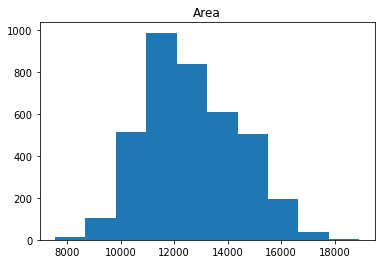

In [14]:
column='Area'
plt.hist(df[column])
plt.title(column)

Perimeter is the circumfrence of the grain of rice

Text(0.5, 1.0, 'Perimeter')

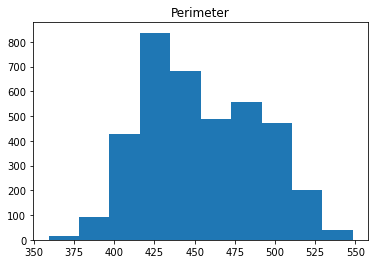

In [15]:
column='Perimeter'
plt.hist(df[column])
plt.title(column)

Major_Axis_Length is the length of the longest line that can be made on the grain of rice

Text(0.5, 1.0, 'Major_Axis_Length')

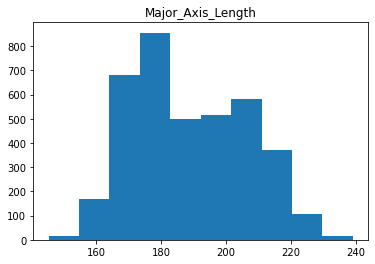

In [16]:
column='Major_Axis_Length'
plt.hist(df[column])
plt.title(column)

Minor_Axis_Length is the shortest length that can be drawn on the grain of rice

Text(0.5, 1.0, 'Minor_Axis_Length')

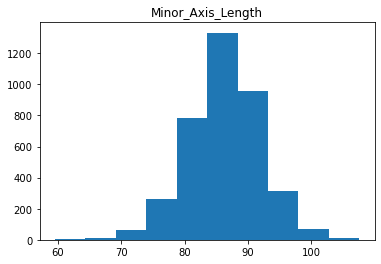

In [17]:
column='Minor_Axis_Length'
plt.hist(df[column])
plt.title(column)

Eccentricity is a measure of how round the ellipse is

Text(0.5, 1.0, 'Eccentricity')

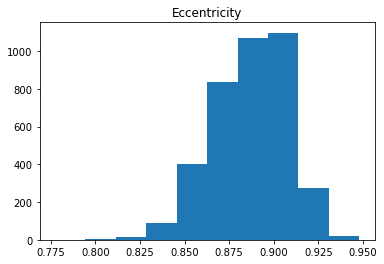

In [18]:
column='Eccentricity'
plt.hist(df[column])
plt.title(column)

Convex_Area is the pixel count of the smallest convex shell of the region formed by the grain of rice

Text(0.5, 1.0, 'Convex_Area')

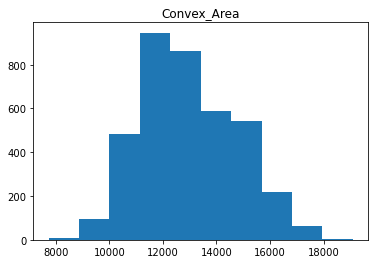

In [19]:
column='Convex_Area'
plt.hist(df[column])
plt.title(column)

Extent is the ratio of the region formed by the grain of rice to the bounding box

Text(0.5, 1.0, 'Extent')

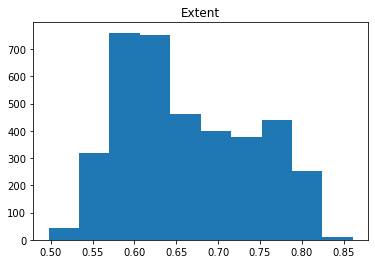

In [20]:
column='Extent'
plt.hist(df[column])
plt.title(column)

The distribution of the features look to be normal. There is some skewing but this is not a cause for concern.

### Check for correlation

 I will create a pairplot to get a visual of how the pairwise relationships between the features.

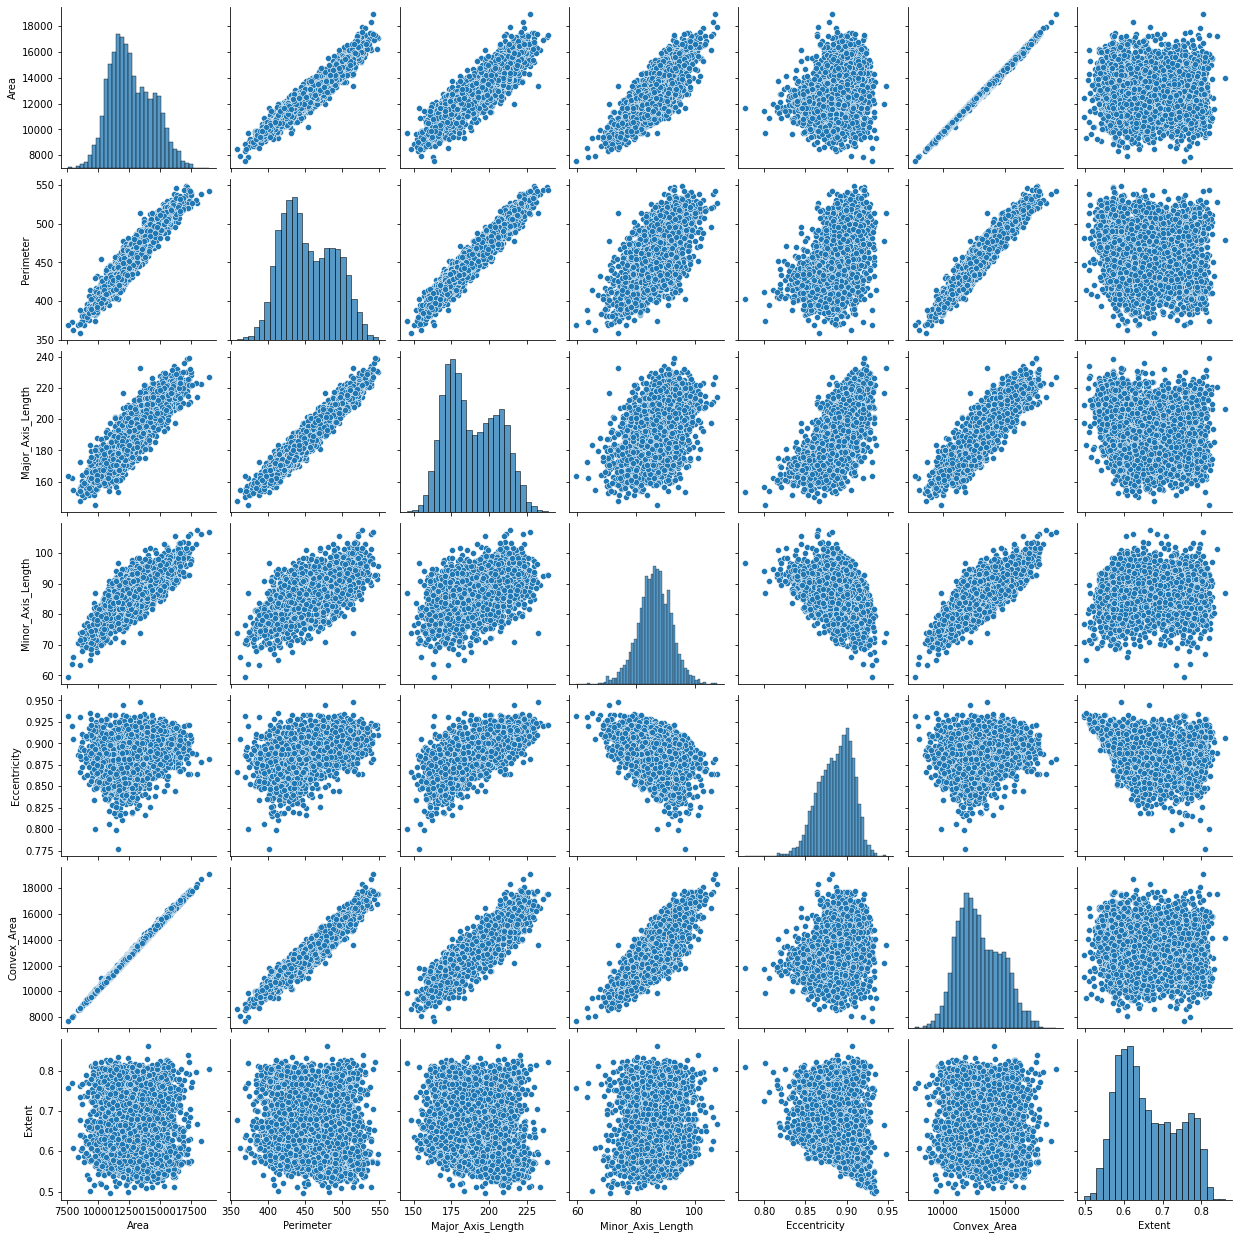

In [21]:
sns.pairplot(df)

Viewing the pairplot it is clear that Area and Convex_Area are multicollinear as the points form an almost perfect line. There are also other linear scatter plots involving Perimeter, Major_Axis_Length and Minow_Axis_Length. I will create heatplots as another way to visualize the correlation and see the correlation coefficients

<AxesSubplot:>

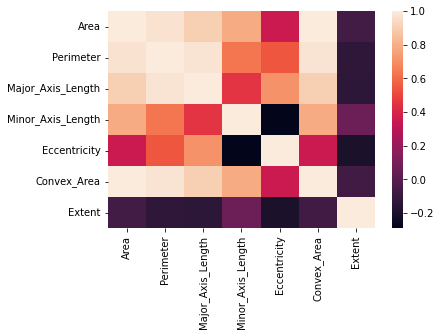

In [22]:
sns.heatmap(df.corr())

The heatmap above shows that there are a number features show strong, postive correlations.

In [23]:
df.corr()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent
Area,1.000000,0.966453,0.903015,0.787840,0.352095,0.998939,-0.061184
Perimeter,0.966453,1.000000,0.971884,0.629828,0.544601,0.969937,-0.130923
Major_Axis_Length,0.903015,0.971884,1.000000,0.452092,0.710897,0.903381,-0.139562
Minor_Axis_Length,0.787840,0.629828,0.452092,1.000000,-0.291683,0.787318,0.063366
Eccentricity,0.352095,0.544601,0.710897,-0.291683,1.000000,0.352716,-0.198580
Convex_Area,0.998939,0.969937,0.903381,0.787318,0.352716,1.000000,-0.065826
Extent,-0.061184,-0.130923,-0.139562,0.063366,-0.198580,-0.065826,1.000000


I will plot some correlation heatmaps with subsets of the features for help with feature selection.

<AxesSubplot:>

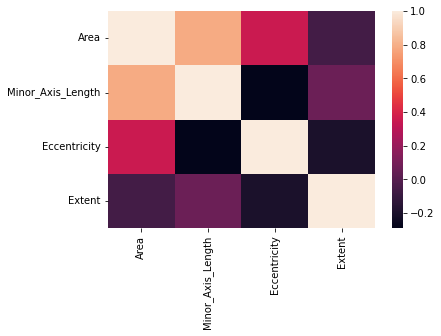

In [24]:
sns.heatmap(df[['Area','Minor_Axis_Length','Eccentricity','Extent']].corr())

In [25]:
df[['Area','Minor_Axis_Length','Eccentricity','Extent']].corr()

,Area,Minor_Axis_Length,Eccentricity,Extent
Area,1.000000,0.787840,0.352095,-0.061184
Minor_Axis_Length,0.787840,1.000000,-0.291683,0.063366
Eccentricity,0.352095,-0.291683,1.000000,-0.198580
Extent,-0.061184,0.063366,-0.198580,1.000000


<AxesSubplot:>

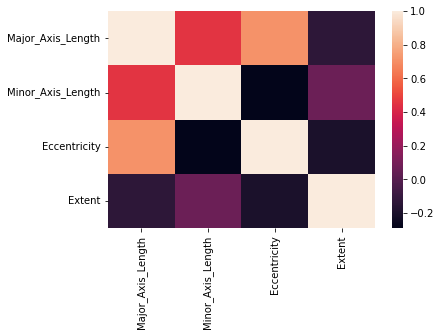

In [26]:
sns.heatmap(df[['Major_Axis_Length','Minor_Axis_Length','Eccentricity','Extent']].corr())

In [27]:
df[['Major_Axis_Length','Minor_Axis_Length','Eccentricity','Extent']].corr()

,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Extent
Major_Axis_Length,1.000000,0.452092,0.710897,-0.139562
Minor_Axis_Length,0.452092,1.000000,-0.291683,0.063366
Eccentricity,0.710897,-0.291683,1.000000,-0.198580
Extent,-0.139562,0.063366,-0.198580,1.000000


<AxesSubplot:>

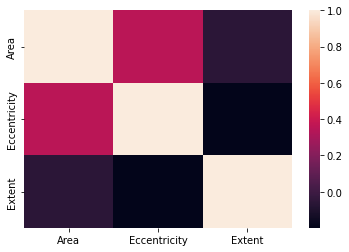

In [28]:
sns.heatmap(df[['Area','Eccentricity','Extent']].corr())

In [29]:
df[['Area','Eccentricity','Extent']].corr()

,Area,Eccentricity,Extent
Area,1.000000,0.352095,-0.061184
Eccentricity,0.352095,1.000000,-0.198580
Extent,-0.061184,-0.198580,1.000000


By looking at multiple correlation matricies I can determime what features are strongly correlated when using different combinations. It is clear that the features that are size measurements are positively correlated. If I keep "Area" as the only size feature all correlation coefficients are less than 0.5. Since Area is something that measures the total size of the rice and not just a single part like Minor_Axis_Length, I will keep Area and remove the rest of the linearly correlated features.

### Modeling

In [30]:
results = {}

In [31]:
# Split data into features and predictions
X = df[['Area','Eccentricity','Extent']]
y = df[['Class']]

In [32]:
#Split data for model training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

To begin I am going to create a decision tree model. I want to see how the base model will perform with default parameters.

In [33]:
clf1 = DecisionTreeClassifier()
clf1.fit(X_train,y_train)

y_pred = clf1.predict(X_test)

In [34]:
print('Accuracy: ',accuracy_score(y_test,y_pred))
print('Precision: ',precision_score(y_test,y_pred,pos_label='Osmancik'))
print('Recall: ',recall_score(y_test,y_pred,pos_label='Osmancik'))
print('F1 score: ',f1_score(y_test,y_pred,pos_label='Osmancik'))
print('Depth: ',clf1.tree_.max_depth)
print('Leaves: ',clf1.get_n_leaves())

Accuracy:  0.8871391076115486
Precision:  0.9117647058823529
Recall:  0.8955555555555555
F1 score:  0.9035874439461884
Depth:  21
Leaves:  265


In [35]:
results['Model 1'] = {'model':'DT','tuned':False,'accuracy':round(accuracy_score(y_test,y_pred),3),'F1 score':round(f1_score(y_test,y_pred,pos_label='Osmancik'),3)}

The precision and recall isn't bad but can certainly be improved. I will use GridSearchCV to help tune my parameters and determine the best values to use for max_depth and min_samples_leaf, which determines how many samples are requried at a leaf node.

In [36]:
dt = DecisionTreeClassifier()
parameters = {'max_depth':[i for i in range(3, 27, 1)],'min_samples_leaf':[i for i in range(1, 31, 1)]}
clf2 = GridSearchCV(dt,parameters)
clf2.fit(X_train,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                       15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                       25, 26],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29, 30]})

In [37]:
clf2.best_estimator_

DecisionTreeClassifier(max_depth=6, min_samples_leaf=20)

In [38]:
clf2.best_score_

0.9196193706425475

Now that I have tuned the hyperparameters, I will run the data with those values and see what the test accuracy is.

In [39]:
clf3 = DecisionTreeClassifier(max_depth=6,min_samples_leaf=20)
clf3.fit(X_train,y_train)

y_pred3 = clf3.predict(X_test)

In [40]:
print('Accuracy: ',accuracy_score(y_test,y_pred3))
print('Precision: ',precision_score(y_test,y_pred3,pos_label='Osmancik'))
print('Recall: ',recall_score(y_test,y_pred3,pos_label='Osmancik'))
print('F1 score: ',f1_score(y_test,y_pred3,pos_label='Osmancik'))
print('Depth: ',clf3.tree_.max_depth)
print('Leaves: ',clf3.get_n_leaves())

Accuracy:  0.9173228346456693
Precision:  0.9448275862068966
Recall:  0.9133333333333333
F1 score:  0.9288135593220338
Depth:  6
Leaves:  40


In [41]:
results['Model 2'] = {'model':'DT','tuned': True,'accuracy':round(accuracy_score(y_test,y_pred3),3),'F1 score':round(f1_score(y_test,y_pred3,pos_label='Osmancik'),3)}

The accuracy, precision and recall have all improved with the tuned hyperparameters. I will create a visualization to see what the resulting tree looks like.

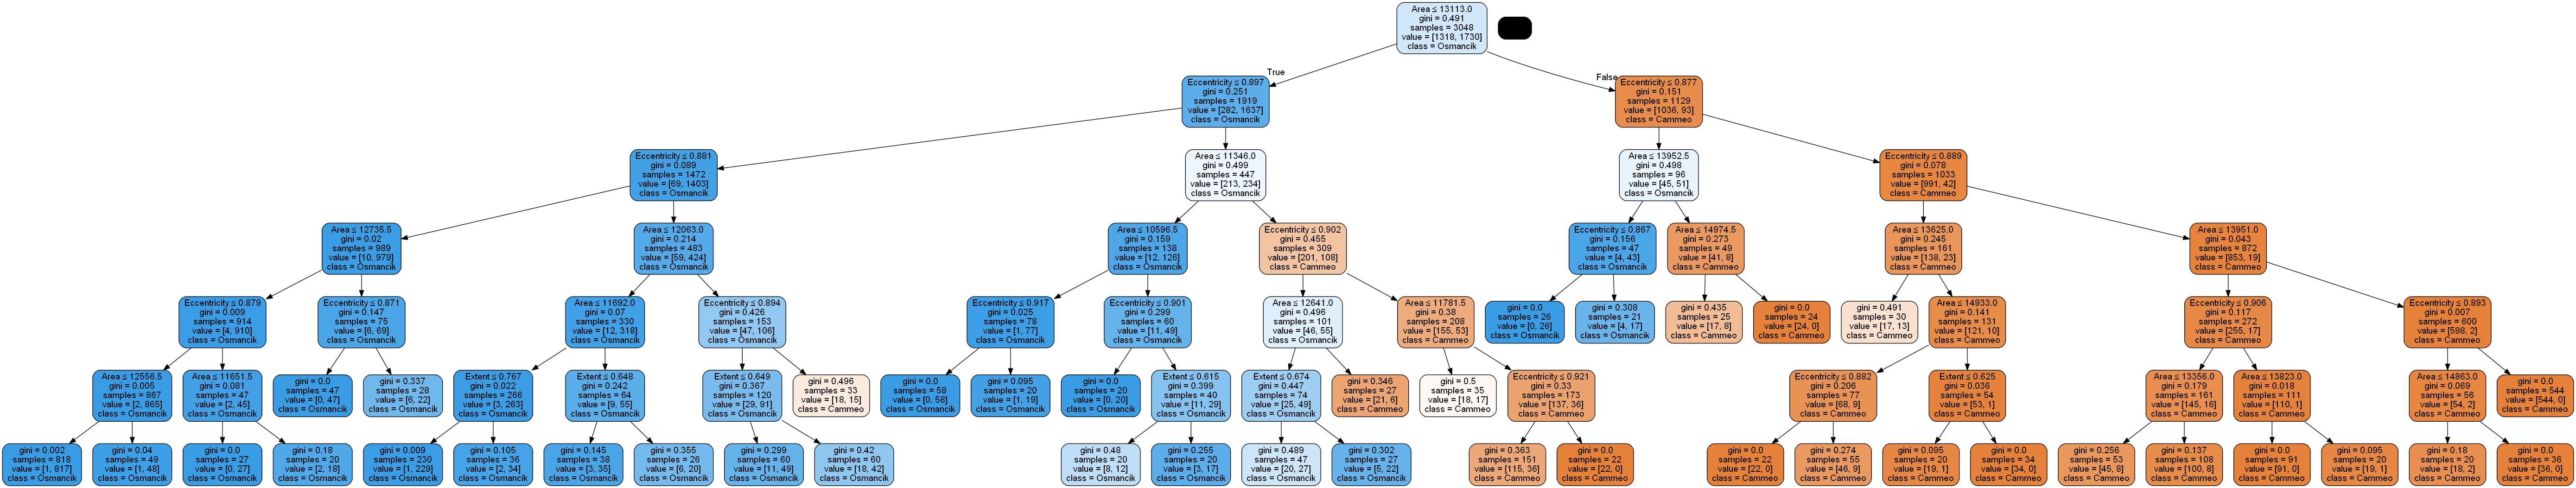

In [42]:
dot_data = StringIO()
feature_cols=X.columns
export_graphviz(clf3,out_file=dot_data,filled=True,rounded=True,special_characters=True,feature_names = feature_cols,class_names=['Cammeo','Osmancik'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

It is still a pretty large tree and I want to be sure I selected the best model and features for this problem. I am going to create a random forest classifier with all of the original features. I will use feature importance to determine the most informative features and then try to improve my decision tree classifier using that knowledge.

In [43]:
Xrf = df[['Area', 'Perimeter', 'Major_Axis_Length', 'Minor_Axis_Length','Eccentricity', 'Convex_Area', 'Extent']]
yrf = df[['Class']]

#Split data for model training and testing
Xrf_train, Xrf_test, yrf_train, yrf_test = train_test_split(Xrf, yrf, test_size=0.2, random_state=17)

rf = RandomForestClassifier()
rf.fit(Xrf_train,yrf_train.values.ravel())

RandomForestClassifier()

In [44]:
yrf_pred = rf.predict(Xrf_test)

In [45]:
print('Accuracy: ',accuracy_score(yrf_test, yrf_pred))
print('Precision: ',precision_score(yrf_test, yrf_pred,pos_label='Osmancik'))
print('Recall: ',recall_score(yrf_test, yrf_pred,pos_label='Osmancik'))
print('F1 score: ',f1_score(yrf_test,yrf_pred,pos_label='Osmancik'))

Accuracy:  0.9120734908136483
Precision:  0.9303370786516854
Recall:  0.92
F1 score:  0.9251396648044694


In [46]:
results['Model 3'] = {'model':'RF','tuned': np.nan,'accuracy':round(accuracy_score(yrf_test, yrf_pred),3),'F1 score':round(f1_score(yrf_test, yrf_pred,pos_label='Osmancik'),3)}

The initial random forest classifier has strong values for accuracy, precision and recall. I am going to use a couple of methods to determine feature importance.

Text(0.5, 0, 'Random Forest Feature Importance')

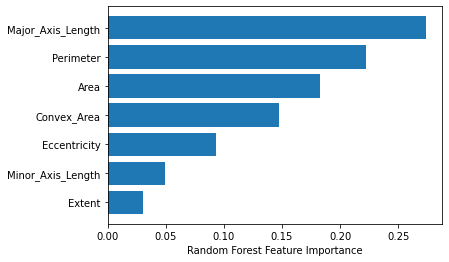

In [47]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(Xrf.columns[sorted_idx],  rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

This bar chart is showing feature importance based on the mean decrease in impurity, the two most important features are Perimeter and Major_Axis_Length, followed by Convex_Area and Area.

In [48]:
perm_importance = permutation_importance(rf, Xrf_test, yrf_test)

Text(0.5, 0, 'Permutation Importance')

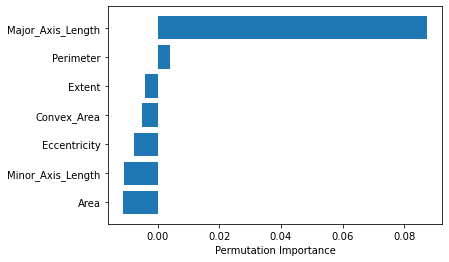

In [49]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(Xrf.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

This bar chart is showing feature importance based on Permutation Importance. Perimeter is again the most important feature followed by Major_Axis_Length and then Convex_Area. I want to update the features I used for the decision tree classifier to see if it will improve performace.

In [50]:
print('Accuracy: ',accuracy_score(y_test,y_pred))
print('Precision: ',precision_score(y_test,y_pred,pos_label='Osmancik'))
print('Recall: ',recall_score(y_test,y_pred,pos_label='Osmancik'))
print('F1 score: ',f1_score(y_test,y_pred,pos_label='Osmancik'))
print('Depth: ',clf1.tree_.max_depth)
print('Leaves: ',clf1.get_n_leaves())

Accuracy:  0.8871391076115486
Precision:  0.9117647058823529
Recall:  0.8955555555555555
F1 score:  0.9035874439461884
Depth:  21
Leaves:  265


Above are the outputs from my original decision tree model.

In [51]:
Xdt = df[['Perimeter','Major_Axis_Length','Convex_Area','Eccentricity']]
ydt = df[['Class']]

In [52]:
#Split data for model training and testing
Xdt_train, Xdt_test, ydt_train, ydt_test = train_test_split(Xdt, ydt, test_size=0.2, random_state=17)

In [53]:
clf4 = DecisionTreeClassifier()
clf4.fit(Xdt_train,ydt_train)

ydt_pred = clf4.predict(Xdt_test)

In [54]:
print('Accuracy: ',accuracy_score(ydt_test,ydt_pred))
print('Precision: ',precision_score(ydt_test,ydt_pred,pos_label='Osmancik'))
print('Recall: ',recall_score(ydt_test,ydt_pred,pos_label='Osmancik'))
print('F1 score: ',f1_score(ydt_test,ydt_pred,pos_label='Osmancik'))
print('Depth: ',clf4.tree_.max_depth)
print('Leaves: ',clf4.get_n_leaves())

Accuracy:  0.889763779527559
Precision:  0.9103139013452914
Recall:  0.9022222222222223
F1 score:  0.90625
Depth:  22
Leaves:  234


This untuned classifier performed better than my original decision tree model. I will now tune the hyperparameters.

In [55]:
results['Model 4'] = {'model':'DT','tuned': False,'accuracy':round(accuracy_score(ydt_test,ydt_pred),3),'F1 score':round(f1_score(ydt_test,ydt_pred,pos_label='Osmancik'),3)}

In [56]:
# Print original tuned results for comparison
print('Accuracy: ',accuracy_score(y_test,y_pred3))
print('Precision: ',precision_score(y_test,y_pred3,pos_label='Osmancik'))
print('Recall: ',recall_score(y_test,y_pred3,pos_label='Osmancik'))
print('F1 score: ',f1_score(y_test,y_pred3,pos_label='Osmancik'))
print('Depth: ',clf3.tree_.max_depth)
print('Leaves: ',clf3.get_n_leaves())

Accuracy:  0.9173228346456693
Precision:  0.9448275862068966
Recall:  0.9133333333333333
F1 score:  0.9288135593220338
Depth:  6
Leaves:  40


Above is the performance results from my first tuned decision tree model.

In [57]:
dt2 = DecisionTreeClassifier()
parameters = {'max_depth':[i for i in range(3, 27, 1)],'min_samples_leaf':[i for i in range(1, 31, 1)]}
clf5 = GridSearchCV(dt2,parameters)
clf5.fit(Xdt_train,ydt_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                       15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                       25, 26],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29, 30]})

In [58]:
clf5.best_estimator_

DecisionTreeClassifier(max_depth=4, min_samples_leaf=26)

In [59]:
clf5.best_score_

0.9278198605615225

In [60]:
clf6 = DecisionTreeClassifier(max_depth=4,min_samples_leaf=26)
clf6.fit(Xdt_train,ydt_train)

y_pred6 = clf6.predict(Xdt_test)

In [61]:
print('Accuracy: ',accuracy_score(ydt_test,y_pred6))
print('Precision: ',precision_score(ydt_test,y_pred6,pos_label='Osmancik'))
print('Recall: ',recall_score(ydt_test,y_pred6,pos_label='Osmancik'))
print('F1 score: ',f1_score(ydt_test,y_pred6,pos_label='Osmancik'))
print('Depth: ',clf6.tree_.max_depth)
print('Leaves: ',clf6.get_n_leaves())

Accuracy:  0.9225721784776902
Precision:  0.9393258426966292
Recall:  0.9288888888888889
F1 score:  0.9340782122905028
Depth:  4
Leaves:  14


This model produced the highest accuracy and F1 score. It also has the smallest depth and number of leaves.

In [62]:
results['Model 5'] = {'model':'DT','tuned': True,'accuracy':round(accuracy_score(ydt_test,y_pred6),3),'F1 score':round(f1_score(ydt_test,y_pred6,pos_label='Osmancik'),3)}

### Results

I kept a dictionary of model results so I could compare them all side-by-side. That was transformed into the dataframe in the output below. My final model, the decision tree with updated parameter and also hyperparameter tuning performed the best. It had the highest accuracy and F1 score. I chose F1 score to accompany accuracy as a performance metric because it considered both precision and recall. The dataset is also slightly unbalanced with one class having more examples than the other which is addressed with the F1 score.

In [63]:
pd.DataFrame.from_dict(results,orient='index').sort_values(by='accuracy',ascending=False)

,model,tuned,accuracy,F1 score
Model 5,DT,True,0.923,0.934
Model 2,DT,True,0.917,0.929
Model 3,RF,NaN,0.912,0.925
Model 4,DT,False,0.890,0.906
Model 1,DT,False,0.887,0.904


Let's take a look at the best decision tree

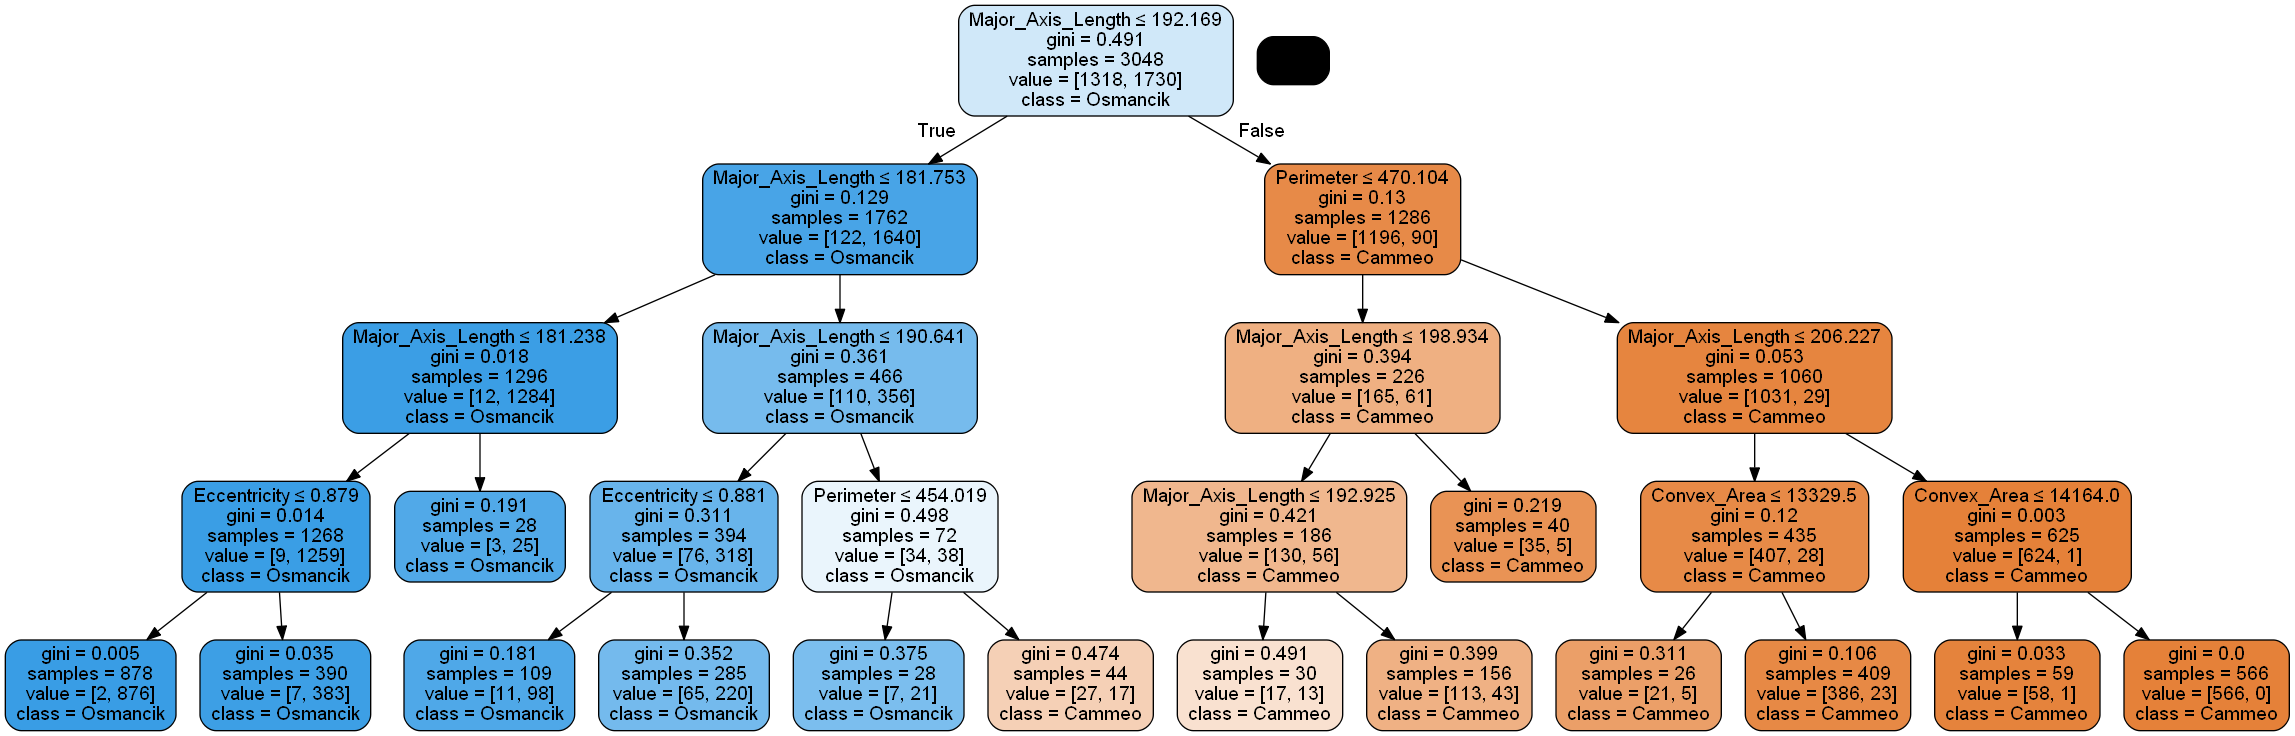

In [64]:
# Tree Visualization
dot_data = StringIO()
feature_cols=Xdt.columns
export_graphviz(clf6,out_file=dot_data,filled=True,rounded=True,special_characters=True,feature_names = feature_cols,class_names=['Cammeo','Osmancik'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

The resulting tree is smaller than the first hyperparameter tuned decision tree model. This makes it a lot easier to follow visually, and also aids in the computational cost when running the model. 

Text(0.7, 0.2, 'AUC=0.972')

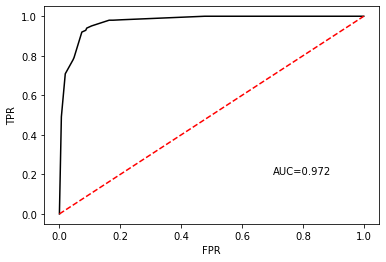

In [65]:
ypp = clf6.predict_proba(Xdt_test)
fpr, tpr, th = roc_curve(ydt_test,ypp[:,1],pos_label='Osmancik')
auc = roc_auc_score(ydt_test,ypp[:,1],labels=['Osmancik','Cammeo'])
plt.plot(fpr,tpr,'k-')
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.text(0.7,0.2,'AUC='+"{:.3f}".format(auc))

I decided to look at the AUC as one last metric to visualize how the model is performing. It has a high AUC and the line is hugging the top left corner indicating that the model has good performance for classifying the two species of rice.

### Conclusion

For this project I found that a decision tree model using the features Perimeter, Major_Axis_Length, Convex_Area, and Eccentricity with a max_depth of 4 and min_samples_leaf of 26 to perform the best when classifying rice species. I was able to improve upon my intial model by tuning the hyperparameters using GridSearchCV. I also improved the model by using a random forest classifier to help me choose the most informative features. Using those methods allowed for a smaller and more accurate decision tree.

While I was able to train a strong model, there is still more exploring that could be done. I decided to use GridSearchCV in order to tune the hyperparameters. I could have also used the cost complexity pruning parameter $\alpha$ to prune the tree after training to help improve accuracy. I also only used the Random Forest classifier to help with feature selection. Another next step would be to focus on the Random Forest model to see if optimizing would create a stronger model than what I ended with.